In [2]:
from __future__ import print_function
from __future__ import division
from __future__ import unicode_literals


In [3]:
import numpy as np

print("Expected cross entropy loss if the model:")
print("- learns neither dependency:", -(0.625 * np.log(0.625) +
                                      0.375 * np.log(0.375)))
# Learns first dependency only ==> 0.51916669970720941
print("- learns first dependency:  ",
      -0.5 * (0.875 * np.log(0.875) + 0.125 * np.log(0.125))
      -0.5 * (0.625 * np.log(0.625) + 0.375 * np.log(0.375)))
print("- learns both dependencies: ", -0.50 * (0.75 * np.log(0.75) + 0.25 * np.log(0.25))
      - 0.25 * (2 * 0.50 * np.log (0.50)) - 0.25 * (0))

Expected cross entropy loss if the model:
- learns neither dependency: 0.6615632381579821
- learns first dependency:   0.5191666997072094
- learns both dependencies:  0.4544543674493905


In [4]:
import numpy as np
import tensorflow as tf
%matplotlib inline
import matplotlib.pyplot as plt
import os
os.environ['CUDA_VISIBLE_DEVICES']=''

D:\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [5]:
# Global config variables
num_steps = 10 # number of truncated backprop steps ('n' in the discussion above)
batch_size = 200
num_classes = 2
state_size = 16
learning_rate = 0.001

In [6]:
def gen_data(size=1000000):
    X = np.array(np.random.choice(2, size=(size,)))
    Y = []
    for i in range(size):
        threshold = 0.5
        if X[i-3] == 1:
            threshold += 0.5
        if X[i-8] == 1:
            threshold -= 0.25
        if np.random.rand() > threshold:
            Y.append(0)
        else:
            Y.append(1)
    return X, np.array(Y)

# adapted from https://github.com/tensorflow/tensorflow/blob/master/tensorflow/models/rnn/ptb/reader.py
def gen_batch(raw_data, batch_size, num_steps):
    raw_x, raw_y = raw_data
    data_length = len(raw_x)

    # partition raw data into batches and stack them vertically in a data matrix
    batch_partition_length = data_length // batch_size
    data_x = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    data_y = np.zeros([batch_size, batch_partition_length], dtype=np.int32)
    for i in range(batch_size):
        data_x[i] = raw_x[batch_partition_length * i:batch_partition_length * (i + 1)]
        data_y[i] = raw_y[batch_partition_length * i:batch_partition_length * (i + 1)]
    # further divide batch partitions into num_steps for truncated backprop
    epoch_size = batch_partition_length // num_steps

    for i in range(epoch_size):
        x = data_x[:, i * num_steps:(i + 1) * num_steps]
        y = data_y[:, i * num_steps:(i + 1) * num_steps]
        yield (x, y)

def gen_epochs(n, num_steps):
    for i in range(n):
        yield gen_batch(gen_data(), batch_size, num_steps)


In [12]:
tf.reset_default_graph()
"""
Placeholders
"""

x = tf.placeholder(tf.int32, [batch_size, num_steps], name='input_placeholder')
y = tf.placeholder(tf.int32, [batch_size, num_steps], name='labels_placeholder')
init_state = tf.zeros([batch_size, state_size])

"""
RNN Inputs
"""

# Turn our x placeholder into a list of one-hot tensors:
# rnn_inputs is a list of num_steps tensors with shape [batch_size, num_classes]
rnn_inputs = tf.one_hot(x, num_classes)

cell = tf.nn.rnn_cell.BasicRNNCell(state_size)
rnn_outputs, final_state = tf.nn.dynamic_rnn(cell, rnn_inputs, initial_state=init_state)
print(rnn_outputs)
print(final_state)

Tensor("rnn/transpose_1:0", shape=(200, 10, 16), dtype=float32)
Tensor("rnn/while/Exit_3:0", shape=(200, 16), dtype=float32)


In [13]:
"""
Predictions, loss, training step

Losses is similar to the "sequence_loss"
function from Tensorflow's API, except that here we are using a list of 2D tensors, instead of a 3D tensor. See:
https://github.com/tensorflow/tensorflow/blob/master/tensorflow/contrib/seq2seq/python/ops/loss.py#L30
"""

#logits and predictions
with tf.variable_scope('softmax'):
    W = tf.get_variable('W', [state_size, num_classes])
    b = tf.get_variable('b', [num_classes], initializer=tf.constant_initializer(0.0))

logits = tf.reshape(
    tf.matmul(tf.reshape(rnn_outputs, [-1,state_size]),W) + b,
    [batch_size,num_steps,num_classes])

predictions = tf.nn.softmax(logits)
losses = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y, logits=logits)


EPOCH 0
Average loss at step 100 for last 100 steps: 0.5445354777574539
Average loss at step 200 for last 100 steps: 0.4836550587415695
Average loss at step 300 for last 100 steps: 0.48256509959697724
Average loss at step 400 for last 100 steps: 0.4807286125421524

EPOCH 1
Average loss at step 100 for last 100 steps: 0.48036312490701677
Average loss at step 200 for last 100 steps: 0.4727483198046684
Average loss at step 300 for last 100 steps: 0.469253836274147
Average loss at step 400 for last 100 steps: 0.46756408661603927

EPOCH 2
Average loss at step 100 for last 100 steps: 0.4728195145726204
Average loss at step 200 for last 100 steps: 0.46405362397432326
Average loss at step 300 for last 100 steps: 0.46263598412275314
Average loss at step 400 for last 100 steps: 0.46333157777786255

EPOCH 3
Average loss at step 100 for last 100 steps: 0.4696124720573425
Average loss at step 200 for last 100 steps: 0.46064146488904956
Average loss at step 300 for last 100 steps: 0.460889716744422

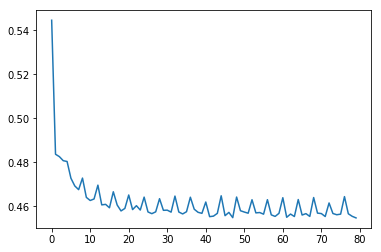

In [14]:
total_loss = tf.reduce_mean(losses)
train_step = tf.train.AdamOptimizer(learning_rate).minimize(total_loss)
"""
Train the network
"""

def train_network(num_epochs, num_steps, state_size=4, verbose=True):
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        training_losses = []
        for idx, epoch in enumerate(gen_epochs(num_epochs, num_steps)):
            training_loss = 0
            training_state = np.zeros((batch_size, state_size))
            if verbose:
                print("\nEPOCH", idx)
            for step, (X, Y) in enumerate(epoch):
                tr_losses, training_loss_, training_state, _ = \
                    sess.run([losses,
                              total_loss,
                              final_state,
                              train_step],
                                  feed_dict={x:X, y:Y, init_state:training_state})
                training_loss += training_loss_
                if step % 100 == 0 and step > 0:
                    if verbose:
                        print("Average loss at step", step,
                              "for last 100 steps:", training_loss/100)
                    training_losses.append(training_loss/100)
                    training_loss = 0

    return training_losses
training_losses = train_network(20,num_steps,state_size=state_size)
plt.plot(training_losses)